In [841]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# from linearmodels.panel.data import PanelData
# from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
import pyblp

In [842]:
save=0
product_data=pd.read_csv("../../data/merged/len3_ndb_blp_DN_firm_FC.csv",encoding="utf-8",index_col=0)
print(product_data.columns[:20])
product_data=product_data.loc[product_data["year"]>2014]
product_data.loc[:,"market_ids"]=product_data.loc[:,"薬効分類"].astype(int).astype(str)+"-"+product_data.loc[:,"year"].astype(int).astype(str)
product_data.loc[:,"firm_ids"]=product_data.loc[:,"メーカー名"].astype(str)
product_data.loc[:,"generic_share_q"].fillna(0,inplace=True)
product_data["generic_share_r"].fillna(0,inplace=True)
product_data.loc[:,"lag_sum_quantity"]=np.log(product_data["lag_sum_quantity"]+0.001)
product_data.loc[:,"otc_dom"]=np.log(product_data["otc_dom"]+0.001)
product_data.loc[:,"薬価_x"]=product_data["薬価_x"].astype(float)
product_data.loc[:,"shares"]=product_data["総計"]/(120000000*100)

product_data.loc[:,"long_run"]=product_data["同一剤形・規格の後発医薬品がある先発医薬品"]
product_data["long_run"].fillna(0,inplace=True)
product_data["long_run"]=product_data["long_run"].replace("○",1)
product_data.rename(columns={"薬価_x":"prices",
                    # "lag_mean_price":"demand_instruments0",
                    # "lag_sum_quantity":"demand_instruments1",
                    # "lag_generic_share_q":"demand_instruments2",
                    "後発品区分":"generic"},inplace=True)
# drop which doesn't have generic
# product_data=product_data[~((product_data["long_run"]==0)&(zproduct_data["generic"]==0))]



product_data=product_data.loc[product_data["shares"]>0]
# product_data=product_data.loc[product_data["prices"].isna()]
# product_data=product_data.dropna(subset=["prices"])
product_data=product_data[["market_ids","firm_ids","prices","oral","generic","in_hospital","薬効分類","year","shares","id_l4","long_run","lag_sum_quantity"]]
product_data["ones"]=1
# data["shares"]=data["r_share"]
product_data.reset_index(drop=True,inplace=True)
print(product_data.columns[:20])
print(product_data.shape)
# product_data.iloc[:,118].isna().sum()

Index(['薬効分類', '薬効分類名称', '医薬品コード', '医薬品名', '薬価基準収載医薬品コード', '薬価_x', '後発品区分',
       '総計', 'year', 'in_hospital', 'oral', 'id_l4', 'Approved', 'KEGG',
       'Ingredient', 'date', 'release_year', '成分', 'variable', 'id_x'],
      dtype='object')
Index(['market_ids', 'firm_ids', 'prices', 'oral', 'generic', 'in_hospital',
       '薬効分類', 'year', 'shares', 'id_l4', 'long_run', 'lag_sum_quantity',
       'ones'],
      dtype='object')
(24448, 13)


C:\Users\hakos\AppData\Local\Temp\ipykernel_30620\2470629864.py:2: DtypeWarning: Columns (118) have mixed types. Specify dtype option on import or set low_memory=False.
  product_data=pd.read_csv("../../data/merged/len3_ndb_blp_DN_firm_FC.csv",encoding="utf-8",index_col=0)


In [843]:
# product_data["long_run"].value_counts()
# product_data["lag_sum_quantity"].isna().sum()
# product_data.shape


In [844]:
demand_instruments=pyblp.build_blp_instruments(pyblp.Formulation("1+generic+oral+generic+long_run"),product_data=product_data)
# demand_instruments=pyblp.build_blp_instruments(formulation=pyblp.Formulation("1+prices+generic+oral+in_hospital"),product_data=product_data)
demand_instruments
demand_instruments.shape,product_data.shape

((24448, 8), (24448, 13))

In [845]:
N_DI=demand_instruments.shape[1]
demand_instruments=pd.DataFrame(demand_instruments, columns=[f'demand_instruments{i}' for i in range(N_DI)])
product_data=pd.concat([product_data,demand_instruments],axis=1)
product_data.columns,product_data.shape

(Index(['market_ids', 'firm_ids', 'prices', 'oral', 'generic', 'in_hospital',
        '薬効分類', 'year', 'shares', 'id_l4', 'long_run', 'lag_sum_quantity',
        'ones', 'demand_instruments0', 'demand_instruments1',
        'demand_instruments2', 'demand_instruments3', 'demand_instruments4',
        'demand_instruments5', 'demand_instruments6', 'demand_instruments7'],
       dtype='object'),
 (24448, 21))

In [846]:
# lagged demand instruments
# demand_instrument_columns = [col for col in product_data.columns if col.startswith('demand_instrument')]
# def lag_demand_instruments(group):
#     for col in demand_instrument_columns:
#         for i in range(N_DI):  # 0から1までのラグを取得
#             lagged_column_name = f'demand_instruments{i+N_DI}'
#             group[lagged_column_name] = group[col].shift(1)
#     return group
# product_data=product_data.sort_values(['薬効分類', 'year'])
# product_data = product_data.groupby('id_l4').apply(lag_demand_instruments)
# product_data.shape

# restrict by year
product_data=product_data[product_data["year"]>2014]
# product_data=product_data[product_data["year"]==2015]
# product_data=product_data[product_data["year"]==2021]
product_data.shape

(24448, 21)

In [867]:
product_data["nesting_ids"]=product_data["long_run"]
logit_formulation= pyblp.Formulation('prices+oral+in_hospital+generic+long_run', absorb='C(market_ids)+C(firm_ids)')
# logit_formulation= pyblp.Formulation('prices+oral+in_hospital+long_run', absorb='C(market_ids)+C(firm_ids)')
# logit_formulation = pyblp.Formulation('prices+oral+generic+long_run', absorb='C(market_ids)+C(firm_ids)')
# logit_formulation = pyblp.Formulation('prices+oral+in_hospital+generic', absorb='C(薬効分類)+C(year)+C(firm_ids)')
# logit_formulation = pyblp.Formulation('prices+oral+in_hospital+generic', absorb='C(薬効分類)')
logit_formulation
# product_data["shares"]-=1e-10

problem = pyblp.Problem(logit_formulation, product_data)
optimization=pyblp.Optimization('slsqp')
logit_results = problem.solve(rho=0.7, optimization=optimization)
logit_results

Initializing the problem ...
Absorbing demand-side fixed effects ...


Detected collinearity issues with [demand_instruments4, oral, generic, long_run] and at least one other column in ZD. Absorbed fixed effects may be creating collinearity problems. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected that the 2SLS weighting matrix is nearly singular with condition number +3.508404E+17. To disable singularity checks, set options.singular_tol = numpy.inf.


Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
175  24448  189   5     12    2     2 

Formulations:
     Column Indices:          0      1         2          3        4    
--------------------------  ------  ----  -----------  -------  --------
X1: Linear Characteristics  prices  oral  in_hospital  generic  long_run
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+7.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    
----  -----------  ------------  -----------  -----------  -----------  -------

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +7.305405E+17. To disable singularity checks, set options.singular_tol = numpy.inf.


Computed results after 00:00:02.

Problem Results Summary:
GMM     Objective      Projected       Reduced     Clipped  Weighting Matrix
Step      Value      Gradient Norm     Hessian     Shares   Condition Number
----  -------------  -------------  -------------  -------  ----------------
 1    +1.171694E+01  +6.665226E+02  -3.218997E+09     0      +1.534766E+17  

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 2     00:00:01         0             1            0            0          0     +2.195701E+01                 +8.014198E+01  +7.000000E-01
 2     00:00:01         0             2      

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +1.001496E+18. To disable singularity checks, set options.singular_tol = numpy.inf.
Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +7.655113E+17. To disable singularity checks, set options.singular_tol = numpy.inf.


Problem Results Summary:
GMM     Objective      Projected       Reduced     Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Gradient Norm     Hessian     Shares   Condition Number  Condition Number 
----  -------------  -------------  -------------  -------  ----------------  -----------------
 2    +1.486735E+01  +2.207775E-08  +4.529705E+02     0      +1.287910E+17      +6.469574E+07  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:17       Yes          3            17     

Rho Estimates (Robust SEs in Parentheses):
  All Groups   
---------------
 +5.230725E-01 
(+9.561517E-02)

Beta Estimates (Robust SEs in Parentheses):
    prices            oral          in_hospital        generic         long_run    
---------------  ---------------  ---------------  ---------------  ---------------
 -1.210863E-04    +1.137253E+00    +2.273046E-

In [902]:
print(np.round(logit_results.beta.T/(1-logit_results.rho),4))

[[-3.0000e-04  2.3845e+00  4.7660e-01 -3.0470e-01 -1.0173e+00]]


In [878]:
instruments_results=logit_results.compute_optimal_instruments()
instruments_results

Computing optimal instruments for theta ...
Computed optimal instruments after 00:00:01.

Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
 00:00:01        1     


Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
 00:00:01        1     

In [897]:
updated_problem=instruments_results.to_problem()
updated_results=updated_problem.solve(rho=0.7,optimization=optimization)
updated_results

Re-creating the problem ...
Absorbing demand-side fixed effects ...
Re-created the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
175  24448  189   5     6     2     2 

Formulations:
     Column Indices:          0      1         2          3        4    
--------------------------  ------  ----  -----------  -------  --------
X1: Linear Characteristics  prices  oral  in_hospital  generic  long_run
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+7.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    
----  ------

Problem Results Summary:
GMM     Objective      Projected       Reduced     Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Gradient Norm     Hessian     Shares   Condition Number  Condition Number 
----  -------------  -------------  -------------  -------  ----------------  -----------------
 2    +1.853313E-20  +9.585652E-09  +2.553068E+03     0      +3.805327E+06      +3.688928E+06  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:09       Yes          4             6     

Rho Estimates (Robust SEs in Parentheses):
  All Groups   
---------------
 +2.951422E-01 
(+2.798877E-02)

Beta Estimates (Robust SEs in Parentheses):
    prices            oral          in_hospital        generic         long_run    
---------------  ---------------  ---------------  ---------------  ---------------
 -1.246652E-04    +1.694726E+00    +3.331316E-

In [898]:
print(np.round(updated_results.beta.T/(1-updated_results.rho),4))

[[-2.0000e-04  2.4044e+00  4.7260e-01 -2.3560e-01 -3.0490e-01]]


Computing marginal costs ...
Finished after 00:00:01.



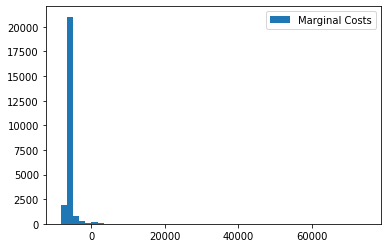

Computing markups ...
Finished after 00:00:00.



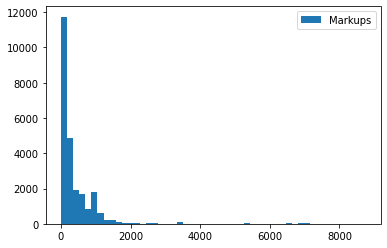

In [899]:
costs = updated_results.compute_costs()
plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);
plt.show()
markups = updated_results.compute_markups(costs=costs)
plt.hist(markups, bins=50)
plt.legend(["Markups"])

In [901]:
cs=updated_results.compute_consumer_surpluses()
sum(cs)

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.



array([274398.02882862])

In [848]:
import datetime

# Get the current date and time
current_time = datetime.datetime.now()

# Format the time as a string
time_string = current_time.strftime("%Y-%m-%d_%H-%M-%S")
if save:
    logit_results.to_pickle(f"./results/MNL_len3_{time_string}.pkl")

In [849]:
elasticities = logit_results.compute_elasticities()

Computing elasticities with respect to prices ...
Finished after 00:00:00.



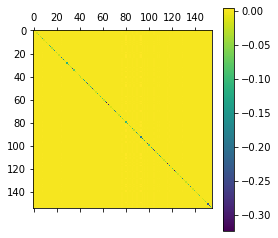

In [850]:
%matplotlib inline
import matplotlib.pyplot as plt
single_market = product_data['market_ids'] == '131-2015'
K=sum(single_market)
plt.colorbar(plt.matshow(elasticities[single_market][:,:K]))

In [851]:
product_data[single_market].shape,K

((155, 22), 155)

In [852]:
elasticities[single_market][:,:K]

array([[-1.14756297e-02,  4.28626504e-05,  2.11230769e-04, ...,
         2.23135966e-04,  9.84895328e-05,  1.61075434e-05],
       [ 1.77845584e-04, -1.16106126e-02,  2.11230769e-04, ...,
         2.23135966e-04,  9.84895328e-05,  1.61075434e-05],
       [ 1.77845584e-04,  4.28626504e-05, -6.66914350e-03, ...,
         2.23135966e-04,  9.84895328e-05,  1.61075434e-05],
       ...,
       [ 1.77845584e-04,  4.28626504e-05,  2.11230769e-04, ...,
        -2.68898514e-01,  9.84895328e-05,  1.61075434e-05],
       [ 1.77845584e-04,  4.28626504e-05,  2.11230769e-04, ...,
         2.23135966e-04, -1.22504194e-01,  1.61075434e-05],
       [ 1.77845584e-04,  4.28626504e-05,  2.11230769e-04, ...,
         2.23135966e-04,  9.84895328e-05, -2.15136245e-02]])

Computing diversion ratios with respect to prices ...
Finished after 00:00:00.



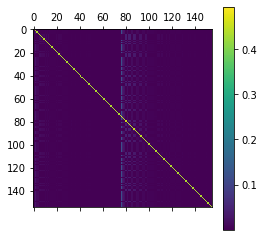

In [853]:
diversions = logit_results.compute_diversion_ratios()
plt.colorbar(plt.matshow(diversions[single_market][:,:K]))